In [12]:
from zero.imports import *
from zero.core import *

### generate random Directed Acyclic Graphs (DAG)
 Several generating algorithms:
 1. Niche model in food webs
 2. Trophic coherent in food webs
 

The niche model uses two fundamental parameters, connectance and number of species, and relies on a one-dimensional niche space or hierarchy. 
Species are given a random niche value $n_i ∼ Uniform (0,1)$ in the hierarchy.
Diets are assigned to each species independently by generating a center and a range as follows. 
Firstly, the feeding range is given by $r_i = n_i x_i$ where $x_i$ is a random number drawn from a Beta distribution, with equation $x_i ∼ Beta (\alpha=1,\beta)$. The distribution is chosen to obtain, on average, the desired connectance. 
Secondly, the centers of the feeding ranges are chosen randomly from species further down in the hierarchy, with equation $c_i ∼ Uniform (r_i/2,n_i)$. Once a feeding range is established for a given species, all species in that range become its prey. 

In [71]:
#export
def niche(s:int, c:int, flip_diag:bool=True):
    """Niche Model for Food Web
    Args:
    - s: number of species in the community
    - c: the connectance, or fraction of realized links in the food web
    
    Return a numpy matrix for a niche model food web.
    a weakly connected DAG (Directed Acyclic Graph)
    """
    weakly_connected = False
    while not weakly_connected:
        b = 1 / (2 * c) - 1
        ni = sorted(np.random.uniform(size = s))
        ri = np.random.beta(a = 1, b = b, size = s) * ni
        ci = np.random.uniform(size = s, low = ri / 2, high = np.minimum(ni, 1 - ri / 2))
        A = np.zeros((s,s))
        for i in range(s):
            for j in range(i+1, s): # 1
                if ni[i] > ci[j] - .5 * ri[j] and ni[i] < ci[j] + .5 * ri[j]:
                    A[i,j] = 1
        if flip_diag:
            A = np.flip(np.rot90(A), axis=1) # rotate 90 degree anti-clockly, then flip along column
        G=nx.from_numpy_matrix(A, create_using=nx.DiGraph())
        weakly_connected = nx.is_weakly_connected(G)
    G.graph['s'] = s
    G.graph['c'] = c
    return A, G    

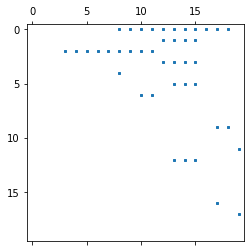

In [72]:
A, G = niche(20, 0.1, flip_diag=True)
plt.spy(A,markersize=2)

### Add unique input node and output node for DAG

In [73]:
#export

"Add unique input node and output node for DAG"
def after_DAG(G):
    n = G.graph['s'] # number of nodes
    
    # find all input nodes and output nodes
    in_nodes = [v for v, d in G.in_degree() if d==0]
    out_nodes = [v for v, d in G.out_degree() if d==0]
    # number of input nodes, number of output nodes, length of longest path
    len(in_nodes), len(out_nodes), nx.dag.dag_longest_path_length(G)

    # add a node with id: -1 as the unique input node
    in_edges = [(-1,i) for i in in_nodes] 
    G.add_edges_from(in_edges)
    # add a node with id: n as the unique output node
    out_edges = [(i, n) for i in out_nodes] 
    G.add_edges_from(out_edges)
    
    return G

In [74]:
G = after_DAG(G)

In [75]:
for id in G.nodes():
    print(id, end=',')

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,-1,20,

### Neural networks constructed based on complex networks

In [76]:
#export
class NodeOP(nn.Module):
    """
    The Operation of every inner node in the network.
    
    Parameters:
    -----------
    Unit : the operation at the node
    kwargs : arguments to Unit
    """
    def __init__(self, ni:int, no:int, nh:int, Unit:nn.Module, **kwargs):
        super(NodeOP, self).__init__()
        self.unit = Unit(ni, no, nh, **kwargs)
            
    def forward(self, *inputs):
        sum_inputs = sum(inputs)        
        out = self.unit(sum_inputs)
        return out
    

In [77]:
#export
class NetworkOP(nn.Module):
    """
    The operations along a DAG network.
    
    Parameters:
    -----------
    G   :  the `NetworkX` 'DiGraph' object, represent a DAG.
    ni  :  number of input channels of the network
    no  :  number of output channel of the network
    Unit : operation at every inner node
    stride : if downsample
    kwargs : arguments to Unit
    
    """
    def __init__(self, G:nx.DiGraph, ni:int, no:int, Unit:nn.Module, stride:int=1, **kwargs):
        super(NetworkOP, self).__init__()
        self.G = G
        self.n = G.graph['s'] # number of nodes
        self.nodeop = nn.ModuleList()
        for id in G.nodes(): # for each node
            if id == -1:  # if is the unique input node, do nothing
                continue
            elif id == self.n:  # if is the unique output node
                # then, concat its predecessors
                n_preds = len([*G.predecessors(id)])
                self.nodeop += [IdentityMapping(n_preds * ni, no, stride=stride)]
            else:  # if is the inner node
                self.nodeop += [NodeOP(ni, ni, ni, Unit, **kwargs)]
            
    def forward(self, x):
        results = {}
        results[-1] = x  # input data is the result of the unique input node
        for id in self.G.nodes():
            if id == -1:  # 
                continue
            inputs = [results[pred]  for pred in self.G.predecessors(id)]
            if id == self.n:
                cat_inputs = torch.cat(inputs, dim=1)
                return self.nodeop[id](cat_inputs)
            else:
                results[id] = self.nodeop[id](*inputs)

            # 删除前驱结点result中，不再需要的result
            for pred in self.G.predecessors(id):  # 获得节点的所有前驱结点
                succs = list(self.G.successors(pred))  # 获得每个前驱结点的所有后继节点
                # 如果排名最后的后继节点是当前节点，说明该前驱结点的result不再被后续的节点需要，可以删除
                if max(succs) == id:  
                    del results[pred]
        


In [94]:
#export
class ComplexNet(nn.Sequential):
    """
    Neural Network based on complex network
    
    Parameters:
    -----------
    Gs  :  a list of `NetworkX DiGraph` objects
    ns  :  number of channels of all stages
    Unit : 
    c_out : number of output channels
    kwargs : additional args to Unit class
    """
    def __init__(self, Gs:list, ns:list, Unit:nn.Module, c_out:int=10, **kwargs):
        super(ComplexNet, self).__init__()
        stem = conv_bn(3, ns[0])
        network_ops = []
        for i in range(len(ns)-2):
            network_ops += [NetworkOP(Gs[i], ns[i], ns[i+1], Unit, stride=2, **kwargs)]
        network_ops += [NetworkOP(Gs[-1], ns[-2], ns[-1], Unit, stride=1, **kwargs)]
        
        classifier = Classifier(ns[-1], c_out)
        super().__init__(
            stem,
            *network_ops,
            classifier
        )
        init_cnn(self)

def complexnet_50():
    species = [50,50,50,50]
    connectance = [0.05]*4
    Gs = [after_DAG(niche(s, c)[1]) for s,c in zip(species, connectance)]
    ns = [32,32,32,32,32]
    model = ComplexNet(Gs, ns, xception)
    return model

In [95]:
model = complexnet_32()

In [97]:
num_params(model)

tensor(855594)

### Export

In [98]:
!python notebook2script.py complexnet.ipynb

Converted complexnet.ipynb to zero/complexnet.py
